In [1]:
import tensorflow as tf
import keras, os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning


In [2]:
# main_dir ="EuroSAT"main_dir +
dataset_folder = "Dataset/EuroSAT/"

In [3]:
import pandas as pd
column_names =  ["id", "path", "class_id", "class_name"]
training_df = pd.read_csv(dataset_folder + "train.csv", names=column_names,header=1)
validation_df = pd.read_csv(dataset_folder + "validation.csv", names=column_names,header=1)
test_df = pd.read_csv(dataset_folder + "test.csv", names=column_names,header=1)

In [4]:
training_df.head()

,id,path,class_id,class_name
0,3297,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
1,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
2,2223,Industrial/Industrial_453.jpg,4,Industrial
3,4887,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation
4,761,Pasture/Pasture_1780.jpg,5,Pasture


In [5]:
validation_df.head()

,id,path,class_id,class_name
0,2134,Forest/Forest_2638.jpg,1,Forest
1,3518,Highway/Highway_875.jpg,3,Highway
2,3048,River/River_434.jpg,8,River
3,3996,SeaLake/SeaLake_2930.jpg,9,SeaLake
4,4870,AnnualCrop/AnnualCrop_1130.jpg,0,AnnualCrop


In [6]:
test_df.head()

,id,path,class_id,class_name
0,1018,Residential/Residential_504.jpg,7,Residential
1,3,Pasture/Pasture_787.jpg,5,Pasture
2,1011,Residential/Residential_1575.jpg,7,Residential
3,47,Pasture/Pasture_473.jpg,5,Pasture
4,2512,PermanentCrop/PermanentCrop_465.jpg,6,PermanentCrop


In [7]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18899 (70%)
Validation set size: 5399 (20%)
Test set size: 2699 (10%)


In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
training_set = train_datagen.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(100,100),
    batch_size=32,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(100, 100),
    batch_size=32,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(100, 100),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 18899 validated image filenames belonging to 10 classes.
Found 5399 validated image filenames belonging to 10 classes.
Found 2699 validated image filenames belonging to 10 classes.


In [16]:
import numpy as np
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)
pd.DataFrame([class_name_list,count])

,0,1,2,3,4,5,6,7,8,9
0,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
1,2099,2100,2100,1750,1750,1400,1750,2100,1750,2100


In [17]:
import pickle as pkl
import pickle
with open('working/mdl.pickle','wb') as f:
    pickle.dump(class_name_list,f)

In [12]:
file = open('working/mdl.pickle','rb')
class_name_l = pkl.load(file)

In [18]:
class_name_list

array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], dtype='<U20')

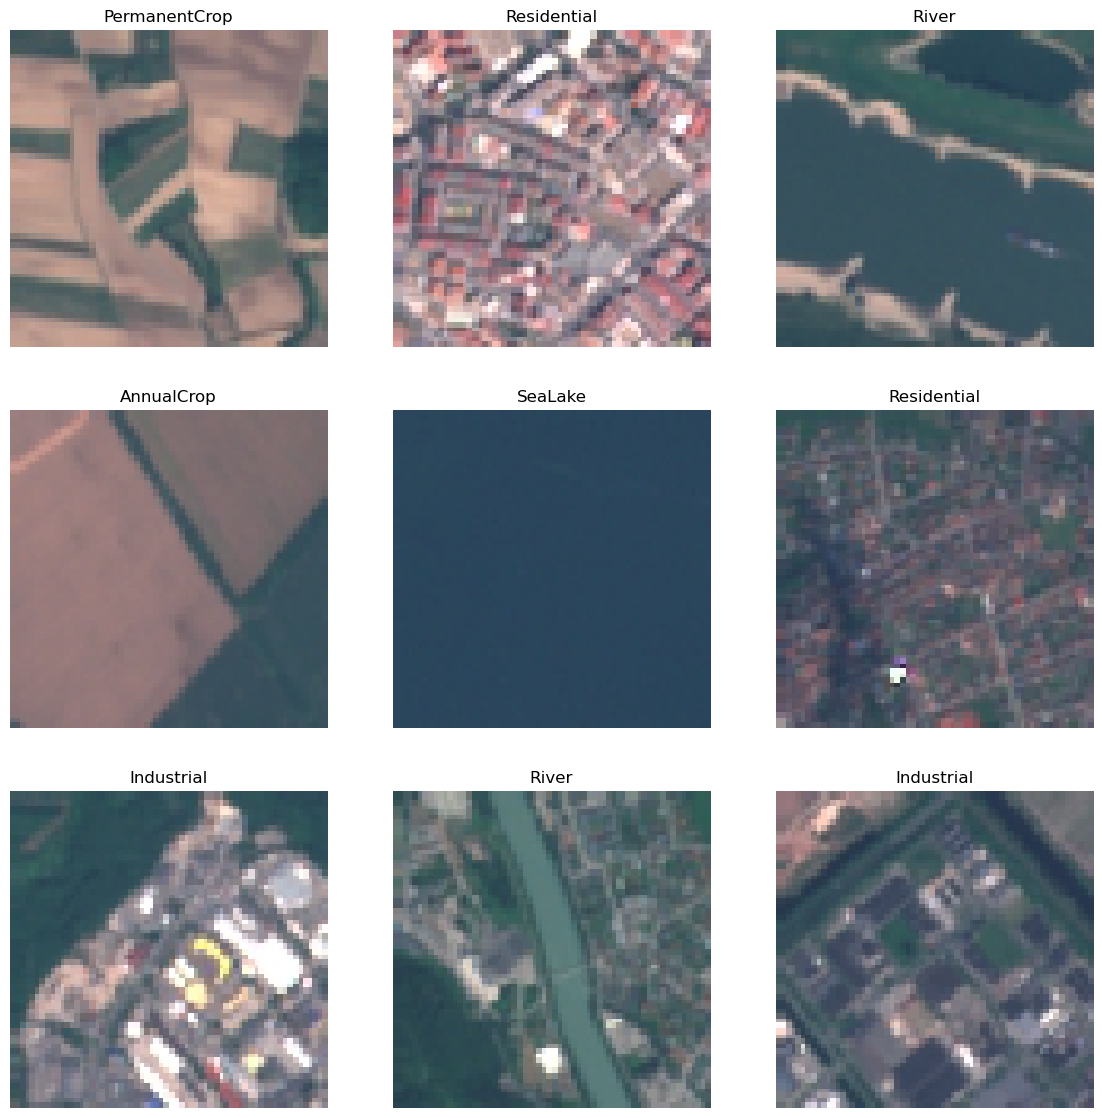

In [19]:
import matplotlib.pyplot as plt
images, class_ids = next(training_set)
plt.figure(figsize=(14,14))
for index in range(3 * 3):
    plt.subplot(3, 3, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

In [20]:
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras import layers
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import BatchNormalization, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
resnet50_model = ResNet50(include_top=False, input_shape=(100, 100, 3))
class_count = len(class_name_list)
resnet5_model = Sequential()
resnet5_model.add(resnet50_model)
resnet5_model.add(Flatten())
resnet5_model.add(Dropout(0.5))
resnet5_model.add(Dense(units=150, activation="relu", kernel_initializer="he_normal"))
resnet5_model.add(Dense(class_count, activation="softmax"))
resnet5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_1 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 150)               4915350   
                                                                 
 dense_3 (Dense)             (None, 10)                1510      
                                                                 
Total params: 28,504,572
Trainable params: 28,451,452
Non-trainable params: 53,120
_________________________________________________________________


In [29]:
resnet5_model_path = "working/models/eurosat_rgb_model_v1.h5"
checkpoint = ModelCheckpoint(filepath=resnet5_model_path, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
callback_list = [checkpoint, early_stopping]

In [30]:
callback_list

In [31]:
resnet5_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [32]:
resnet50_history = resnet5_model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=3,
    verbose=1,
)

Epoch 1/3
591/591 [==============================] - 2885s 5s/step - loss: 0.3933 - accuracy: 0.8869 - val_loss: 7.8273 - val_accuracy: 0.0407
Epoch 2/3
591/591 [==============================] - 2544s 4s/step - loss: 0.1209 - accuracy: 0.9636 - val_loss: 0.2927 - val_accuracy: 0.9107
Epoch 3/3
591/591 [==============================] - 2605s 4s/step - loss: 0.1072 - accuracy: 0.9674 - val_loss: 0.1589 - val_accuracy: 0.9505


In [33]:
loss, accuracy = resnet5_model.evaluate(test_set, verbose=1)

85/85 [==============================] - 88s 1s/step - loss: 0.1581 - accuracy: 0.9559


In [34]:
test_set.reset()

In [42]:
predicted_probabilities = resnet5_model.predict(test_set, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

85/85 [==============================] - 92s 1s/step


In [43]:
predicted_class_ids


array([7, 0, 7, ..., 9, 8, 0], dtype=int64)

In [44]:
test_set.labels

[7,
 5,
 7,
 5,
 6,
 5,
 8,
 8,
 2,
 9,
 1,
 7,
 0,
 2,
 0,
 0,
 8,
 7,
 1,
 0,
 9,
 5,
 9,
 6,
 6,
 3,
 7,
 3,
 4,
 9,
 7,
 7,
 0,
 2,
 7,
 5,
 5,
 3,
 4,
 5,
 6,
 3,
 4,
 6,
 7,
 9,
 8,
 5,
 1,
 9,
 3,
 0,
 9,
 5,
 1,
 2,
 9,
 9,
 1,
 4,
 8,
 2,
 7,
 3,
 9,
 5,
 5,
 0,
 8,
 7,
 9,
 2,
 4,
 1,
 7,
 6,
 3,
 4,
 1,
 2,
 0,
 6,
 0,
 1,
 3,
 5,
 8,
 9,
 6,
 7,
 7,
 0,
 8,
 2,
 3,
 2,
 9,
 9,
 1,
 3,
 4,
 7,
 8,
 4,
 0,
 2,
 7,
 6,
 6,
 4,
 0,
 1,
 9,
 3,
 6,
 5,
 4,
 9,
 9,
 1,
 8,
 1,
 4,
 9,
 2,
 9,
 5,
 3,
 8,
 7,
 5,
 3,
 0,
 6,
 7,
 1,
 0,
 1,
 8,
 8,
 1,
 1,
 1,
 1,
 7,
 7,
 3,
 9,
 2,
 0,
 4,
 2,
 7,
 7,
 5,
 9,
 4,
 1,
 1,
 2,
 6,
 1,
 8,
 5,
 9,
 0,
 2,
 3,
 4,
 2,
 9,
 1,
 1,
 2,
 8,
 0,
 1,
 5,
 3,
 1,
 2,
 3,
 6,
 0,
 6,
 7,
 1,
 5,
 7,
 4,
 1,
 6,
 9,
 0,
 9,
 7,
 7,
 2,
 0,
 8,
 2,
 5,
 4,
 2,
 2,
 2,
 6,
 3,
 2,
 2,
 5,
 8,
 7,
 7,
 3,
 6,
 4,
 8,
 1,
 1,
 8,
 8,
 8,
 5,
 4,
 1,
 1,
 9,
 8,
 5,
 8,
 4,
 3,
 4,
 8,
 3,
 7,
 1,
 2,
 1,
 1,
 0,
 0,
 3,
 1,
 0,
 2,
 5,
 6,
 2,


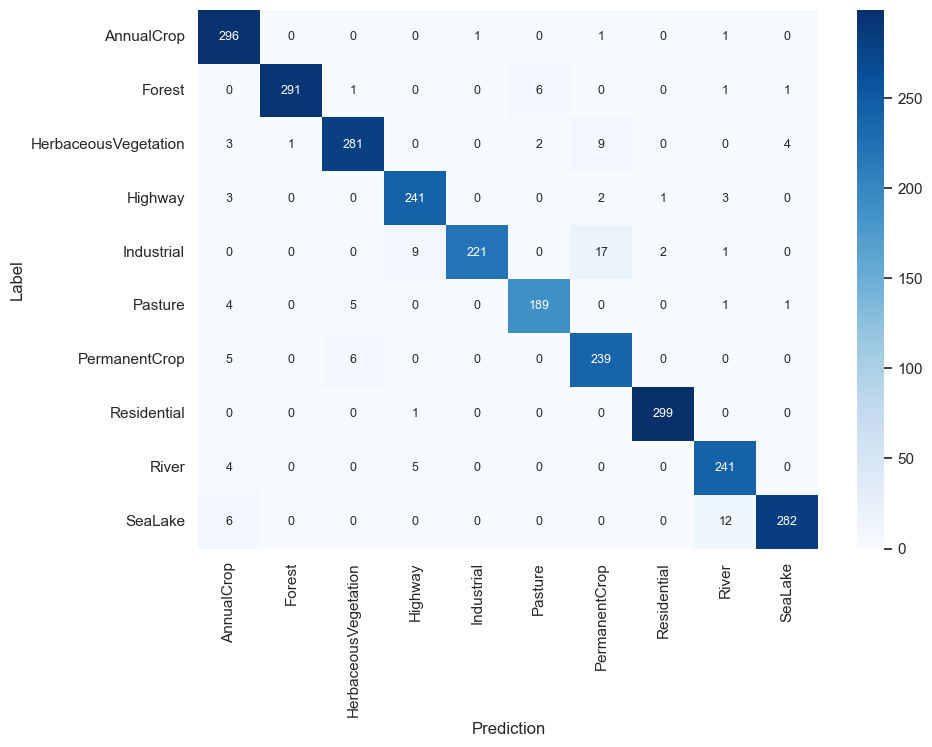

In [46]:
from sklearn.metrics import confusion_matrix

from matplotlib import image
import seaborn as sns





confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()



In [47]:
resnet50_results_df = pd.DataFrame(
    {
        "Original_labels": class_name_list[test_set.labels],
        "Original_values": test_set.labels,
        "Predicted_labels": class_name_list[predicted_class_ids],
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

In [48]:
resnet50_results_df

,Original_labels,Original_values,Predicted_labels,prediction,path
0,Residential,7,Residential,7,Dataset/EuroSAT/Residential/Residential_504.jpg
1,Pasture,5,AnnualCrop,0,Dataset/EuroSAT/Pasture/Pasture_787.jpg
2,Residential,7,Residential,7,Dataset/EuroSAT/Residential/Residential_1575.jpg
3,Pasture,5,Pasture,5,Dataset/EuroSAT/Pasture/Pasture_473.jpg
4,PermanentCrop,6,PermanentCrop,6,Dataset/EuroSAT/PermanentCrop/PermanentCrop_46...
...,...,...,...,...,...
2694,HerbaceousVegetation,2,HerbaceousVegetation,2,Dataset/EuroSAT/HerbaceousVegetation/Herbaceou...
2695,HerbaceousVegetation,2,HerbaceousVegetation,2,Dataset/EuroSAT/HerbaceousVegetation/Herbaceou...
2696,SeaLake,9,SeaLake,9,Dataset/EuroSAT/SeaLake/SeaLake_2696.jpg
2697,River,8,River,8,Dataset/EuroSAT/River/River_472.jpg


In [62]:
resnet50_results_df['path'][0]

'Dataset/EuroSAT/Residential/Residential_504.jpg'

In [49]:
class_name_list[test_set.labels]

array(['Residential', 'Pasture', 'Residential', ..., 'SeaLake', 'River',
       'AnnualCrop'], dtype='<U20')

In [67]:
from tensorflow.keras import utils
# test_img = utils.load_img(r"C:\Users\david\Data_Sciences\DL\Kaggle\EuroSAT\Dataset\EuroSAT\AnnualCrop\AnnualCrop_37.jpg",target_size=(100,100,3))

In [70]:
image = tf.keras.utils.load_img(r"Dataset/EuroSAT/Residential/Residential_504.jpg", target_size=(100,100,3))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
output_class_id = np.argmax(predictions, axis=1)
class_name_list[output_class_id]

1/1 [==============================] - 0s 76ms/step


array(['Residential'], dtype='<U20')

In [73]:
model.save(r'working\models\rgbmodel.h5')

In [11]:
#3rd Model

In [12]:
VGG_19_model = VGG19(input_shape=(64,64,3),weights='imagenet',include_top= False)
model = Sequential()
model.add(VGG_19_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))

80134624/80134624 [==============================] - 10s 0us/step


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
VGG16_history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=3,
    verbose=1,
)

In [ ]:
model_path = "/working/models/eurosat_vgg19_model_v1.hdf5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
callback_list = [checkpoint, early_stopping]

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)

In [ ]:
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

from matplotlib import image
import seaborn as sns





confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()



In [ ]:
VGG19_results_df = pd.DataFrame(
    {
        "Original_labels": class_name_list[test_set.labels],
        "Original_values": test_set.labels,
        "Predicted_labels": class_name_list[predicted_class_ids],
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

In [ ]:
VGG16_results_df

In [ ]:
#prediction of random image
image = tf.keras.utils.load_img(r"C:\Users\david\Data Sciences\DL\Kaggle\EuroSAT\Dataset\EuroSAT\AnnualCrop\AnnualCrop_37.jpg", target_size=(64,64,3))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
output_class_id = np.argmax(predictions, axis=1)
class_name_list[output_class_id]